![Py4Eng](img/logo.png)

# Object detection
## Yoav Ram

In [1]:
import urllib.request
import os
import zipfile
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
from ipywidgets import interact
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)

from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Object detection in an image

We will use a [sign language dataset](https://medium.freecodecamp.org/weekend-projects-sign-language-and-static-gesture-recognition-using-scikit-learn-60813d600e79) that includes both images and bounding box data to try and learn to **find the bounding boxes** of sign language gestures in images.

## The data

Now let's get the data:

In [2]:
fname = '../data/sign-lang.zip'
url = 'https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/raw/master/Dataset.zip'
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
print(fname, 'exists:', os.path.exists(fname))

../data/sign-lang.zip exists: True


In [3]:
folder = fname.replace('.zip', '')
if not os.path.exists(folder):
    print('Extracting to {}'.format(folder))
    with zipfile.ZipFile(fname) as f:
        f.extractall('../data/')
    os.rename('../data/Dataset', folder)
print(folder, 'exists:', os.path.exists(folder))

../data/sign-lang exists: True


We have folder for different users; each user folders has JPEG images and a single metadata CSV file.

In [4]:
%ls ../data/sign-lang
%ls ../data/sign-lang/user_5/

user_10/ user_3/  user_4/  user_5/  user_6/  user_7/  user_9/
A0.jpg          E9.jpg          K8.jpg          P7.jpg          U6.jpg
A1.jpg          F0.jpg          K9.jpg          P8.jpg          U7.jpg
A2.jpg          F1.jpg          L0.jpg          P9.jpg          U8.jpg
A3.jpg          F2.jpg          L1.jpg          Q0.jpg          U9.jpg
A4.jpg          F3.jpg          L2.jpg          Q1.jpg          V0.jpg
A5.jpg          F4.jpg          L3.jpg          Q2.jpg          V1.jpg
A6.jpg          F5.jpg          L4.jpg          Q3.jpg          V2.jpg
A7.jpg          F6.jpg          L5.jpg          Q4.jpg          V3.jpg
A8.jpg          F7.jpg          L6.jpg          Q5.jpg          V4.jpg
A9.jpg          F8.jpg          L7.jpg          Q6.jpg          V5.jpg
B0.jpg          F9.jpg          L8.jpg          Q7.jpg          V6.jpg
B1.jpg          G0.jpg          L9.jpg          Q8.jpg          V7.jpg
B2.jpg          G1.jpg          M0.jpg          Q9.jpg          V8.jpg
B3.jpg         

We'll read the images with `imageio` (`conda install imageio pillow -c conda-forge`).

In [31]:
def open_image(fname):
    return imageio.imread(fname)

im = open_image(os.path.join(folder, 'user_3', 'A0.jpg'))
print(im.dtype, im.shape)

uint8 (240, 320, 3)


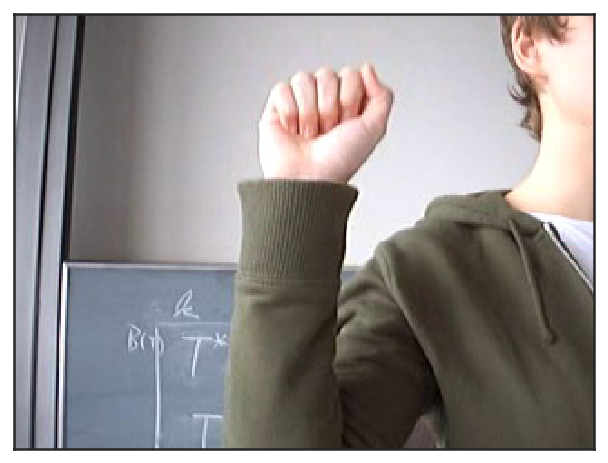

In [32]:
def display_image(im, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(im)
    ax.set(xticks=[], yticks=[])
    return ax

display_image(im);

We can open the metadata CSV file with pandas:

In [7]:
def open_metadata(fname):
    return pd.read_csv(fname)

In [8]:
metadata_fname = os.path.join(folder, 'user_3', 'user_3_loc.csv')
metadata = open_metadata(metadata_fname)
metadata.head()

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_3/A0.jpg,124,18,214,108
1,user_3/A1.jpg,124,18,214,108
2,user_3/A2.jpg,123,19,213,109
3,user_3/A3.jpg,122,21,212,111
4,user_3/A4.jpg,122,20,212,110


# Bounding box

OK, let's see how those `x`s and `y`s relate to the image.

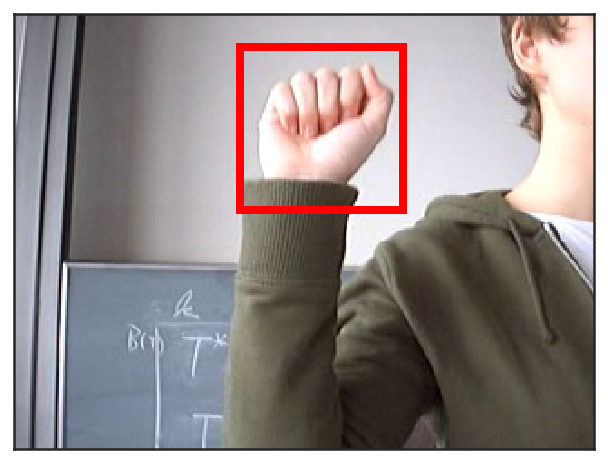

In [9]:
row = metadata[metadata['image']=='user_3/A0.jpg']
tlx, tly, brx, bry = [
    row[k].values[0]
    for k in ['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']
]

ax = display_image(im)
rect = plt.Rectangle((tlx, bry), brx-tlx, tly-bry, fill=False, color='r', lw=4)
ax.add_artist(rect)

We'll write a new function to display the image plus any provided boxes (later we will have both the real box and the predicted one).

In [30]:
def display_image2(im, *boxes, ax=None):
    ax = display_image(im.astype('uint8'), ax)
    for box, c, ls in zip(boxes, sns.color_palette('Set1'), ['-', '--']):
        tlx, tly, brx, bry = box
        rect = plt.Rectangle((tlx, bry), brx-tlx, tly-bry, 
                             fill=False, color=c, lw=4, ls=ls)
        ax.add_artist(rect)
    return ax

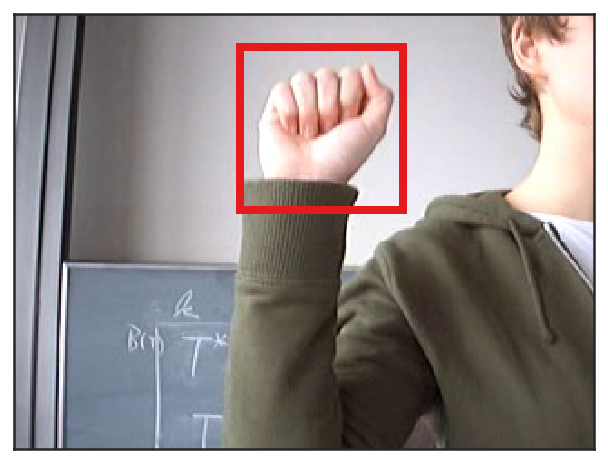

In [11]:
display_image2(im, (tlx, tly, brx, bry));

Let's open all the files and metadata:

In [12]:
metadata_fnames = []
for dirpath, dirnames, filenames in os.walk(folder):
    for fname in filenames:
        if fname.endswith('.csv'):
            metadata_fnames.append(os.path.join(dirpath, fname))
metadata_fnames

['../data/sign-lang/user_5/user_5_loc.csv',
 '../data/sign-lang/user_3/user_3_loc.csv',
 '../data/sign-lang/user_4/user_4_loc.csv',
 '../data/sign-lang/user_6/user_6_loc.csv',
 '../data/sign-lang/user_9/user_9_loc.csv',
 '../data/sign-lang/user_7/user_7_loc.csv',
 '../data/sign-lang/user_10/user_10_loc.csv']

In [13]:
metadata = pd.concat(pd.read_csv(fname) for fname in metadata_fnames)
metadata = metadata.sample(frac=1, replace=False) # shuffle
print(metadata.shape)
metadata.head()

(1680, 5)


,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
56,user_10/F6.jpg,172,23,292,143
35,user_3/D5.jpg,34,3,194,163
176,user_5/S6.jpg,200,38,300,138
88,user_6/I8.jpg,199,83,319,203
15,user_3/B5.jpg,3,23,193,213


In [14]:
images = [open_image(os.path.join(folder, fname)) for fname in metadata['image']]
images = np.array(images)
images.shape

(1680, 240, 320, 3)

We'll reshape and extract the relevant columns to get an `X` and `Y` arrays.

In [15]:
n_samples, width, height, channels = images.shape

In [16]:
metadata.columns

Index(['image', 'top_left_x', 'top_left_y', 'bottom_right_x',
       'bottom_right_y'],
      dtype='object')

In [17]:
X = images.reshape(n_samples, -1)
Y = metadata[['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']]
X.shape, Y.shape

((1680, 230400), (1680, 4))

# Multiple linear regression

We are ready! 
Let's just start with a multiple linear regression model -- a baseline, reference, shallow model.

Let's split and fit.

If the fitting takes long you can give it just a subset of the data or increaes `n_jobs`.

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values, test_size=0.25, random_state=9)

In [71]:
lm = linear_model.LinearRegression(fit_intercept=False)
lm.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [208]:
print("Final MSE: {}".format(((lm.predict(X_test) - Y_test)**2).mean()))

Final MSE: 108.7875574337119


[Serialize model to file](http://scikit-learn.org/stable/modules/model_persistence.html):

In [72]:
if input("Are you sure? (N/y)").lower() == 'y':
    with open('../data/sign-lang-lm.pkl', 'wb') as f:
        pickle.dump(lm, f)

Are you sure? (N/y)y


Load model from file:

In [73]:
with open('../data/sign-lang-lm.pkl', 'rb') as f:
    lm = pickle.load(f)

Let's see how it works for some random image; first functions to predict and get the truth.

In [33]:
def true_box(idx):
    return Y_test[idx]

def predict_box(idx, model):
    X_ = X_test[idx]
    if X_.ndim == 1:
        X_ = X_.reshape(1, -1)
    return model.predict(X_).ravel().astype(int)

Let's see the results.

(array([ 54,  29, 183, 158]), array([ 80,  31, 210, 161]))

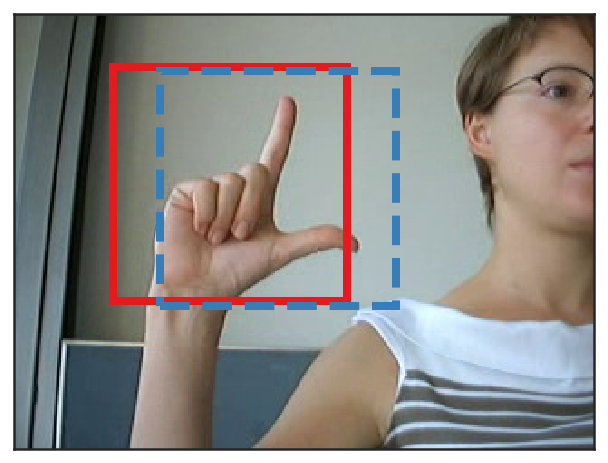

In [76]:
idx = 5
im = X_test[idx].reshape(width, height, channels)
pred = predict_box(idx, model=lm)
truth = true_box(idx)
display_image2(im, pred, truth);
pred, truth

# Metric - IoU

To measure the model performence we will use the IoU - intersection over union - metric.

![IoU](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

![IoU](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_examples.png)

[source](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

In [36]:
def IoU(box1, box2):
    tlx1, tly1, brx1, bry1 = box1
    tlx2, tly2, brx2, bry2 = box2
    if (tlx1 >= brx1 or 
        tly1 >= bry1  or
        tlx2 >= brx2 or 
        tly2 >= bry2):
        return 0
    
    dx = min(brx1, brx2) - max(tlx1, tlx2)
    dy = min(bry1, bry2) - max(tly1, tly2)
    inter_area = dx * dy

    area1 = (brx1 - tlx1) * (bry1 - tly1)
    area2 = (brx2 - tlx2) * (bry2 - tly2)
    union_area = area1 + area2 - inter_area
    
    return inter_area / union_area

In [78]:
@interact(idx=(0, len(X_test)-1))
def predict_and_score(idx):
    im = X_test[idx].reshape(width, height, channels)
    pred = predict_box(idx, model=lm)
    truth = true_box(idx)
    print('IoU', IoU(pred, truth))
    display_image2(im, pred, truth)  

interactive(children=(IntSlider(value=209, description='idx', max=419), Output()), _dom_classes=('widget-interact',))

# Exercise - IoU

1. Calculate the scores over all the test images
1. Assert that all scores are between 0 and 1
1. Print the mean, 95% confidence interval
1. Plot a histogram of the scores
1. Bonus: plot the mean and CI using `plt.axvline` and `plt.fill_between`.

In [80]:
truth = Y_test
pred = lm.predict(X_test)
scores = np.array([IoU(p, t) for p, t in zip(pred, truth)])

In [81]:
assert (0 <= scores).all()
assert (1 >= scores).all()

avg = scores.mean()
low, high = np.percentile(scores, 2.5), np.percentile(scores, 97.5)
print("Mean IoU {:.3f}".format(avg))
print("95% CI {:.3f}-{:.3f}".format(low, high))

Mean IoU 0.778
95% CI 0.546-0.951


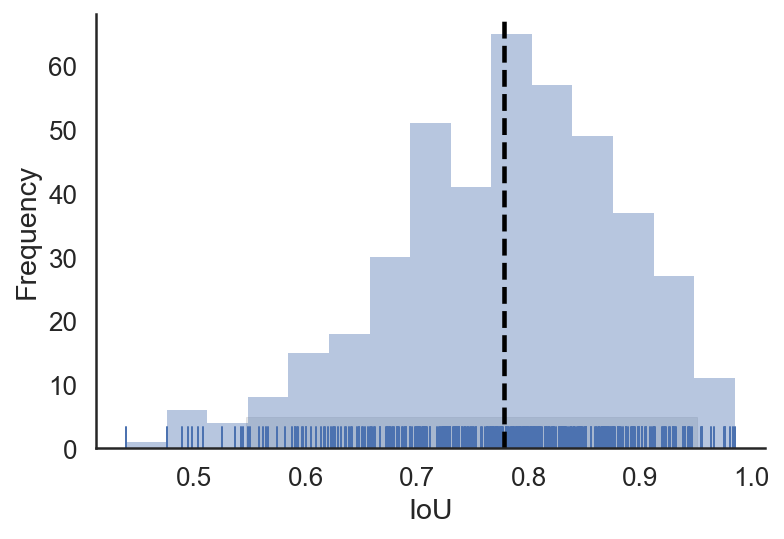

In [83]:
sns.distplot(scores, rug=True, kde=False)
plt.axvline(scores.mean(), color='k', ls='--')
plt.fill_between([low, high], [5, 5], alpha=0.1, color='k')
plt.xlabel('IoU')
plt.ylabel('Frequency')
sns.despine()

# Exercise - broadcasting challenge

Can you implement the IoU function to work on arrays using broadcasing?
Hint: use `np.minimum` and `np.maxmimum`.

# Exercise - Neural network
Implement a simple linear regression with Keras.

Note that a Keras linear regression is prone to explosing loss function and exploding gradients (which is not a problem with scikit-learn, probably because it does not use gradient descent).
This will manifest in NaN values in the loss function, the learned weights, and the predictions.

To [mitigate this problem](https://stackoverflow.com/a/37242531/1063612), use combinations of:
- an adaptive optimizer like Adam
- Dropout layer
- big batches
- kernel regularization in the dense layer

In [19]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [197]:
layers = [
    keras.layers.Dense(4, use_bias=False, kernel_regularizer='l2', input_shape=(width * height * channels,))
]

lmk = keras.models.Sequential(layers)
lmk.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 4)                 921600    
Total params: 921,600
Trainable params: 921,600
Non-trainable params: 0
_________________________________________________________________


In [198]:
lmk.compile(optimizer='adam', loss='mse')

In [199]:
history = lmk.fit(X_train, Y_train, batch_size=512, epochs=100, verbose=0).history

Epoch 1/100
 - 2s - loss: 396670730.0540
Epoch 2/100
 - 2s - loss: 381263063.7714
Epoch 3/100
 - 2s - loss: 70018378.1841
Epoch 4/100
 - 2s - loss: 230343128.0508
Epoch 5/100
 - 2s - loss: 27585034.8190
Epoch 6/100
 - 2s - loss: 120303184.5460
Epoch 7/100
 - 2s - loss: 15679879.6190
Epoch 8/100
 - 2s - loss: 63914963.2635
Epoch 9/100
 - 2s - loss: 10230540.0000
Epoch 10/100
 - 2s - loss: 33368133.0635
Epoch 11/100
 - 2s - loss: 7921191.6222
Epoch 12/100
 - 2s - loss: 15731011.4425
Epoch 13/100
 - 2s - loss: 7143748.2381
Epoch 14/100
 - 2s - loss: 5972403.8738
Epoch 15/100
 - 2s - loss: 6291376.0794
Epoch 16/100
 - 2s - loss: 1620321.6897
Epoch 17/100
 - 2s - loss: 4312597.0508
Epoch 18/100
 - 2s - loss: 843545.3111
Epoch 19/100
 - 2s - loss: 1830616.9676
Epoch 20/100
 - 2s - loss: 1190983.8881
Epoch 21/100
 - 2s - loss: 398204.8105
Epoch 22/100
 - 2s - loss: 919698.1755
Epoch 23/100
 - 2s - loss: 280552.3337
Epoch 24/100
 - 2s - loss: 267573.2416
Epoch 25/100
 - 2s - loss: 357367.4680


In [209]:
@interact(idx=(0, len(X_test)-1))
def predict_and_score(idx):
    im = X_test[idx].reshape(width, height, channels)
    pred = predict_box(idx, model=lmk)
    truth = true_box(idx)
    print('IoU', IoU(pred, truth))
    display_image2(im, pred, truth)  

interactive(children=(IntSlider(value=209, description='idx', max=419), Output()), _dom_classes=('widget-interact',))

In [210]:
truth = Y_test
pred = lmk.predict(X_test)
scores = np.array([IoU(p, t) for p, t in zip(pred, truth)])
scores.mean(), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

(0.46820879780363162, 0.13736989207523864, 0.77581292106749911)

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)